# Librerias

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import BertTokenizer, BertModel
from sklearn.cluster import KMeans
from flair.embeddings import WordEmbeddings, FlairEmbeddings, StackedEmbeddings, DocumentPoolEmbeddings
from flair.data import Sentence
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from mpl_toolkits.mplot3d import Axes3D
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score

/workspaces/Procesamiento-encuesta-docente/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Carga de datos

In [13]:
df = pd.read_csv('../Datos/PlanComun2019-2023.csv')
df.head()

,comentario,nombre_curso,tipo,codigo,semestre,codigo_curso,seccion,anho
0,Explicó bien y se preocupó mucho por las inqui...,Termodinámica,1,FI2004-2,Otoño,FI2004,2,2019
1,Usaba powerpoints con la materia pasada en clases,Termodinámica,1,FI2004-2,Otoño,FI2004,2,2019
2,Muy interesante la relación de los contenidos ...,Termodinámica,1,FI2004-2,Otoño,FI2004,2,2019
3,Excelentes los auxs,Termodinámica,1,FI2004-1,Otoño,FI2004,1,2019
4,Es el primer (y probablemente el único) ramo t...,Termodinámica,1,FI2004-1,Otoño,FI2004,1,2019


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32491 entries, 0 to 32490
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   comentario    32491 non-null  object
 1   nombre_curso  32491 non-null  object
 2   tipo          32491 non-null  int64 
 3   codigo        32491 non-null  object
 4   semestre      32491 non-null  object
 5   codigo_curso  32491 non-null  object
 6   seccion       32491 non-null  int64 
 7   anho          32491 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 2.0+ MB


In [15]:
def preprocesamiento_comments(df):
  '''
   Función que preprocesa los comentarios, eliminando comentarios demasiado cortos y separando el dataframe en comentarios
   positivos y negativos.

   dataframe -> dataframe (+), dataframe (-)
  '''
  df = df.dropna()
  df = df[df['comentario'].apply(lambda x: len(str(x).split()) > 2)]
  df_positivos = df[df['tipo']==1]
  df_negativos = df[df['tipo']==0]
  return df_positivos, df_negativos, df

In [16]:
positivos, negativos, df = preprocesamiento_comments(df)
positivos.head()

,comentario,nombre_curso,tipo,codigo,semestre,codigo_curso,seccion,anho
0,Explicó bien y se preocupó mucho por las inqui...,Termodinámica,1,FI2004-2,Otoño,FI2004,2,2019
1,Usaba powerpoints con la materia pasada en clases,Termodinámica,1,FI2004-2,Otoño,FI2004,2,2019
2,Muy interesante la relación de los contenidos ...,Termodinámica,1,FI2004-2,Otoño,FI2004,2,2019
3,Excelentes los auxs,Termodinámica,1,FI2004-1,Otoño,FI2004,1,2019
4,Es el primer (y probablemente el único) ramo t...,Termodinámica,1,FI2004-1,Otoño,FI2004,1,2019


In [17]:
positivos.to_csv('../Datos/positivos.csv')
negativos.to_csv('../Datos/negativos.csv')

## Carga del archivo de embeddings

El archivo de embeddings se entreno durante 1 hora con stacked embeddings de flair. Por motivos de tiempo la mejor elección es descargarlos para poder usarlos cuando sea necesario.

In [3]:
embeddings_positivos = np.load("../Artifacts/flair-embeddings/embeddings_positivos.npy")
embeddings_negativos = np.load("../Artifacts/flair-embeddings/embeddings_negativos.npy")
print('Dimensiones embeddings positivos: ', embeddings_positivos.shape)
print('Dimensiones embeddings negativos: ', embeddings_negativos.shape)

Dimensiones embeddings positivos:  (17849, 4396)
Dimensiones embeddings negativos:  (13065, 4396)


In [9]:
# Aplicar PCA para reducir las dimensiones a 2

pca = PCA(n_components=2)
positivos_pca = pca.fit_transform(embeddings_positivos)
negativos_pca = pca.fit_transform(embeddings_negativos)

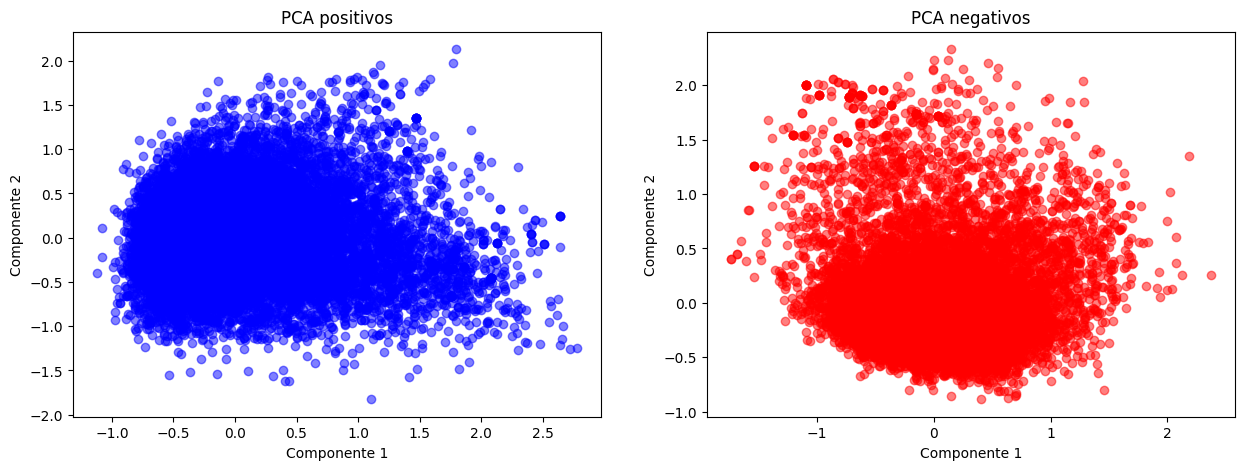

In [10]:
## grafico negativos_pca y positivos_pca

fig, ax = plt.subplots(1,2 ,figsize=(15, 5))

ax[0].scatter(positivos_pca[:,0], positivos_pca[:,1], c='blue', alpha=0.5)
ax[0].set_title('PCA positivos')
ax[0].set_xlabel('Componente 1')
ax[0].set_ylabel('Componente 2')

ax[1].scatter(negativos_pca[:,0], negativos_pca[:,1], c='red', alpha=0.5)
ax[1].set_title('PCA negativos')
ax[1].set_xlabel('Componente 1')
ax[1].set_ylabel('Componente 2')

plt.show()

In [11]:
inertia_p = np.load("../inertia_k-means/flair/inertia_p.npy")
inertia_n = np.load("../inertia_k-means/flair/inertia_n.npy")
print('Inertia positivos: ', inertia_p)
print('Inertia negativos: ', inertia_n)

Inertia positivos:  [60184.82421875 55925.953125   54096.06640625 52797.4296875
 51744.63671875 50924.51171875 50314.3671875  49655.3828125
 49104.76171875 48694.10546875]
Inertia negativos:  [37802.9609375  35711.90234375 34185.1640625  33353.6796875
 32701.57617188 32196.78710938 31741.79882812 31347.54296875
 30976.95507812 30675.58203125]


# Algoritmos de agrupación

Se realizarán pruebas con tres enfoques diferentes: K-means, DBscan y aglomerative clustering.

## K-means

### Método del codo

Metodo para estimar la cantidad de cluster para el modelo.

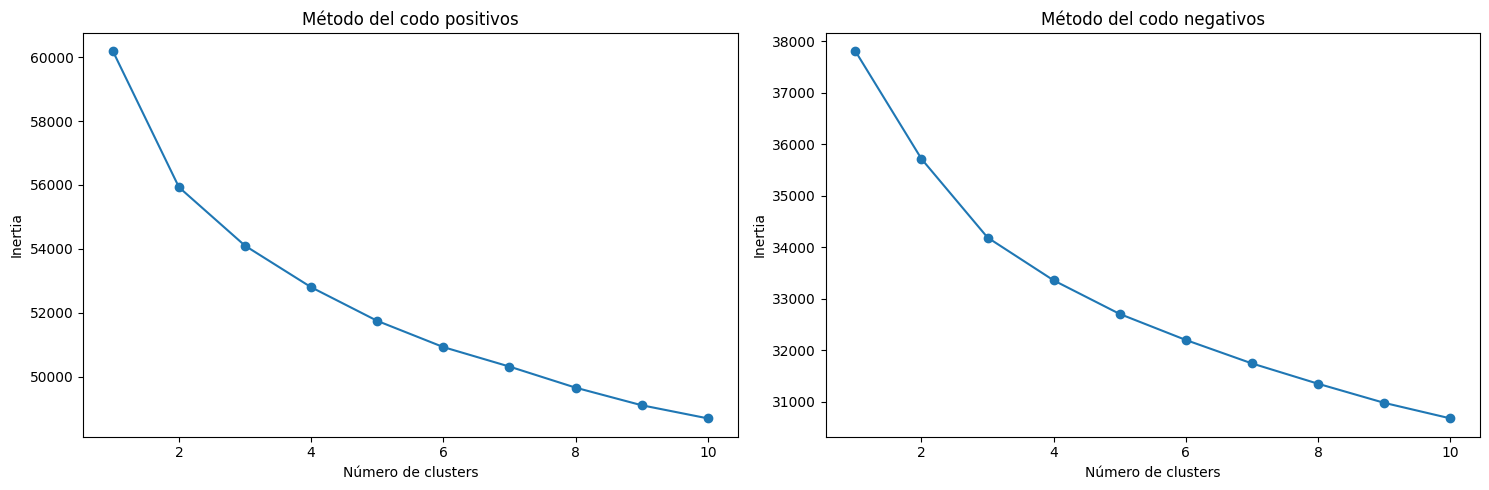

In [12]:
# Subplot para metodo del codo positivos y negativos

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(range(1, 11), inertia_p, marker='o')
axs[0].set_xlabel('Número de clusters')
axs[0].set_ylabel('Inertia')
axs[0].set_title('Método del codo positivos')
axs[1].plot(range(1, 11), inertia_n, marker='o')
axs[1].set_xlabel('Número de clusters')
axs[1].set_ylabel('Inertia')
axs[1].set_title('Método del codo negativos')

# Ajuste del eje y

plt.subplots_adjust(wspace=0.1, hspace=0)
plt.tight_layout()

plt.savefig('Figuras/flair/kmeanscodo_pos_neg.png')
plt.show()

In [13]:
# Aplicación de k-means para positivos y negativos

N_clusters = [2, 3, 4, 5, 6, 7, 8]
Coef_si_kmean_p = []
Coef_si_kmean_n = []

for i in N_clusters:    
    kmeans_p = KMeans(n_clusters=i, random_state=0).fit(embeddings_positivos)
    kmeans_n = KMeans(n_clusters=i, random_state=0).fit(embeddings_negativos)

    Coef_si_kmean_p.append(silhouette_score(embeddings_positivos, kmeans_p.labels_))
    Coef_si_kmean_n.append(silhouette_score(embeddings_negativos, kmeans_n.labels_))

    print('Número de clusters: ', i)
    print('Coeficiente de silouhette positivos: ', silhouette_score(embeddings_positivos, kmeans_p.labels_))
    print('Coeficiente de silouhette negativos: ', silhouette_score(embeddings_negativos, kmeans_n.labels_))
    print('')

/workspaces/Procesamiento-encuesta-docente/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/workspaces/Procesamiento-encuesta-docente/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Número de clusters:  2
Coeficiente de silouhette positivos:  0.22535314
Coeficiente de silouhette negativos:  0.113698



/workspaces/Procesamiento-encuesta-docente/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/workspaces/Procesamiento-encuesta-docente/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Número de clusters:  3
Coeficiente de silouhette positivos:  0.038142975
Coeficiente de silouhette negativos:  0.115504324



/workspaces/Procesamiento-encuesta-docente/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/workspaces/Procesamiento-encuesta-docente/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Número de clusters:  4
Coeficiente de silouhette positivos:  0.018711576
Coeficiente de silouhette negativos:  0.044231866



/workspaces/Procesamiento-encuesta-docente/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/workspaces/Procesamiento-encuesta-docente/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Número de clusters:  5
Coeficiente de silouhette positivos:  0.016284896
Coeficiente de silouhette negativos:  0.0029127002



/workspaces/Procesamiento-encuesta-docente/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/workspaces/Procesamiento-encuesta-docente/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Número de clusters:  6
Coeficiente de silouhette positivos:  0.0045658387
Coeficiente de silouhette negativos:  0.0038592457



/workspaces/Procesamiento-encuesta-docente/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/workspaces/Procesamiento-encuesta-docente/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Número de clusters:  7
Coeficiente de silouhette positivos:  0.006313819
Coeficiente de silouhette negativos:  -0.004228379



/workspaces/Procesamiento-encuesta-docente/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/workspaces/Procesamiento-encuesta-docente/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Número de clusters:  8
Coeficiente de silouhette positivos:  -0.001968999
Coeficiente de silouhette negativos:  -0.005651149



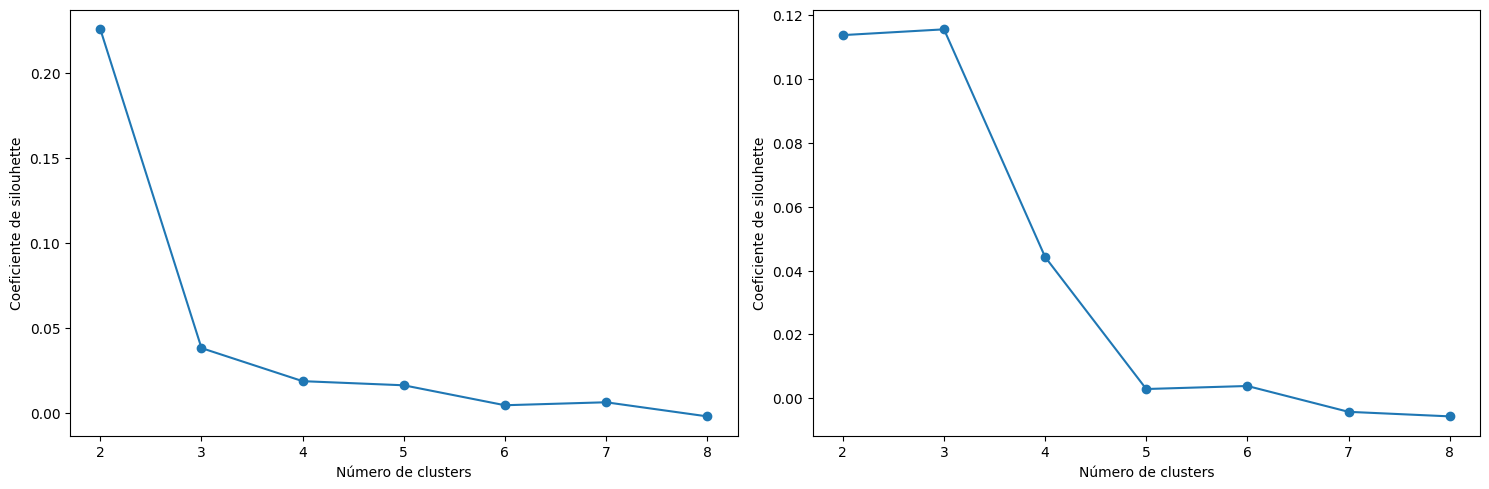

In [15]:
# Grafiación coeficiente de silouhette

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(N_clusters, Coef_si_kmean_p, marker='o')
axs[0].set_xlabel('Número de clusters')
axs[0].set_ylabel('Coeficiente de silouhette')

axs[1].plot(N_clusters, Coef_si_kmean_n, marker='o')
axs[1].set_xlabel('Número de clusters')
axs[1].set_ylabel('Coeficiente de silouhette')

plt.subplots_adjust(wspace=0.1, hspace=0)
plt.tight_layout()

plt.savefig('Figuras/flair/silouhette_pos_neg.png')
plt.show()

In [25]:
## K-means para positivos y negativos

kmeans_p = KMeans(n_clusters=4, random_state=0).fit(embeddings_positivos)
kmeans_n = KMeans(n_clusters=4, random_state=0).fit(embeddings_negativos)

/workspaces/Procesamiento-encuesta-docente/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/workspaces/Procesamiento-encuesta-docente/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


## DBscan



### Método de la rodilla

Para este tipo de cluster basado en densidad, es posible estimar el parametro eps (epsilon) que define el radio de vencindad alrededor de un punto. Con esto en mente, para estimar este epsilon se usa el algoritmo de K vecinos cercanos.

In [16]:
# Aplicación del metodo de la rodilla para positivos y negativos

N = 100
nbrs_p = NearestNeighbors(n_neighbors=N).fit(embeddings_positivos)
distances_p, indices_p = nbrs_p.kneighbors(embeddings_positivos)

nbrs_n = NearestNeighbors(n_neighbors=N).fit(embeddings_negativos)
distances_n, indices_n = nbrs_n.kneighbors(embeddings_negativos)

distances_p = np.sort(distances_p, axis=0)
distances_p = distances_p[:,1]

distances_n = np.sort(distances_n, axis=0)
distances_n = distances_n[:,1]


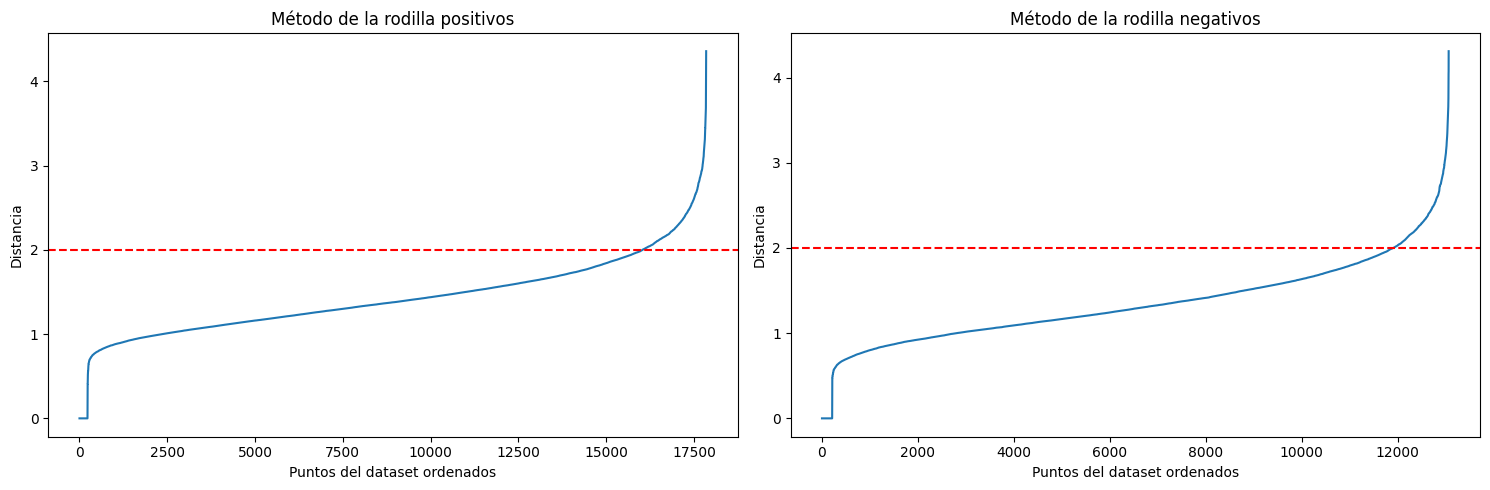

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(distances_p)
axs[0].set_xlabel('Puntos del dataset ordenados')
axs[0].set_ylabel('Distancia')
axs[0].set_title('Método de la rodilla positivos')
axs[0].axhline(y=2, color='r', linestyle='--') #Ajuste el valor para y

axs[1].plot(distances_n)
axs[1].set_xlabel('Puntos del dataset ordenados')
axs[1].set_ylabel('Distancia')
axs[1].set_title('Método de la rodilla negativos')
axs[1].axhline(y=2, color='r', linestyle='--') #Ajuste el valor para y

plt.subplots_adjust(wspace=0.1, hspace=0)
plt.tight_layout()

plt.savefig('Figuras/flair/rodilla_pos_neg.png')
plt.show()

In [18]:
## Modelo Dbscan para positivos y negativos

dbscan_p = DBSCAN(eps=2, min_samples=5).fit(embeddings_positivos)
dbscan_n = DBSCAN(eps=2, min_samples=5).fit(embeddings_negativos)

## Aglomerative clustering

### Matriz de enlace

La matriz de enlace permite visualizar las distancias de cada punto con respecto a los otros.

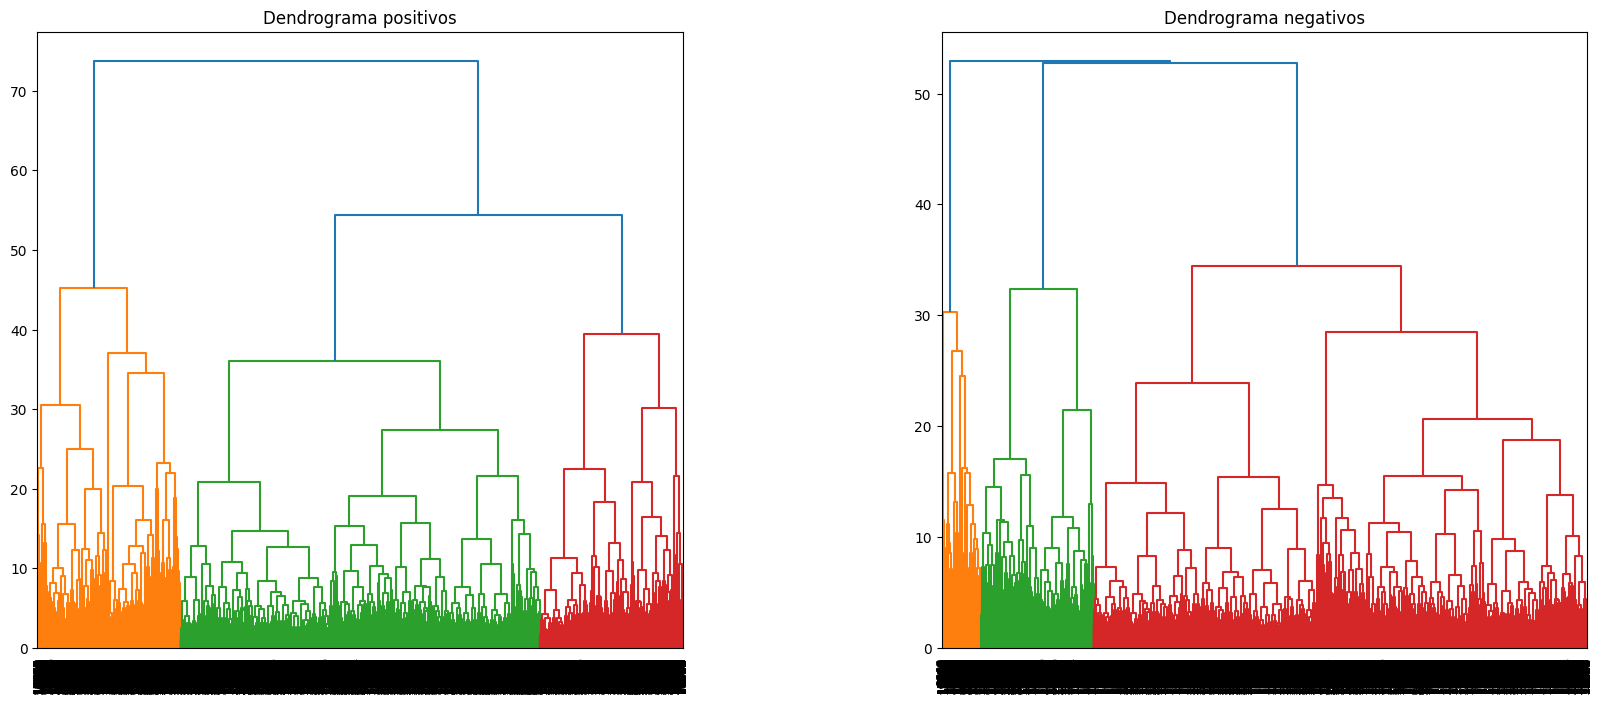

In [19]:
# Calcular la matriz de enlace
linkage_matrix_p = linkage(embeddings_positivos, method='ward')
linkage_matrix_n = linkage(embeddings_negativos, method='ward')

# Graficar el dendrograma
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

axs[0].set_title('Dendrograma positivos')
axs[1].set_title('Dendrograma negativos')

dendrogram(linkage_matrix_p, ax=axs[0], leaf_rotation=90, leaf_font_size=8)
dendrogram(linkage_matrix_n, ax=axs[1], leaf_rotation=90, leaf_font_size=8)

plt.savefig('Figuras/flair/dendrograma_pos_neg.png')
plt.show()

In [ ]:
N_clusters = [3, 4, 5, 6]

Coef_si_p = []
Coef_si_n = []

for i in N_clusters:
    Agglomerativo_p = AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage='ward').fit(embeddings_positivos)
    Agglomerativo_n = AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage='ward').fit(embeddings_negativos)

    Coef_si_p.append(silhouette_score(embeddings_positivos, Agglomerativo_p.labels_))
    Coef_si_n.append(silhouette_score(embeddings_negativos, Agglomerativo_n.labels_))

    print('Número de clusters: ', i)
    print('Coeficiente de silouhette positivos: ', silhouette_score(embeddings_positivos, Agglomerativo_p.labels_))
    print('Coeficiente de silouhette negativos: ', silhouette_score(embeddings_negativos, Agglomerativo_n.labels_))
    print('')

/workspaces/Procesamiento-encuesta-docente/.venv/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/workspaces/Procesamiento-encuesta-docente/.venv/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Número de clusters:  3
Coeficiente de silouhette positivos:  0.042139288
Coeficiente de silouhette negativos:  0.1667942



/workspaces/Procesamiento-encuesta-docente/.venv/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/workspaces/Procesamiento-encuesta-docente/.venv/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Número de clusters:  4
Coeficiente de silouhette positivos:  0.047125384
Coeficiente de silouhette negativos:  -0.008733107



/workspaces/Procesamiento-encuesta-docente/.venv/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/workspaces/Procesamiento-encuesta-docente/.venv/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Número de clusters:  5
Coeficiente de silouhette positivos:  0.0073097628
Coeficiente de silouhette negativos:  -0.0036632023



/workspaces/Procesamiento-encuesta-docente/.venv/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/workspaces/Procesamiento-encuesta-docente/.venv/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Número de clusters:  6
Coeficiente de silouhette positivos:  0.009250954
Coeficiente de silouhette negativos:  -0.0009007936



In [ ]:
# Grafiación coeficiente de silouhette

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(N_clusters, Coef_si_p, marker='o')
axs[0].set_xlabel('Número de clusters')
axs[0].set_ylabel('Coeficiente de silouhette')

axs[1].plot(N_clusters, Coef_si_n, marker='o')
axs[1].set_xlabel('Número de clusters')
axs[1].set_ylabel('Coeficiente de silouhette')

plt.subplots_adjust(wspace=0.1, hspace=0)
plt.tight_layout()

plt.savefig('Figuras/flair/aglosilouhette_pos_neg.png')
plt.show()

### Modelo

In [ ]:
Agglomerativo_p = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward').fit(embeddings_positivos)
Agglomerativo_n = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward').fit(embeddings_negativos)

/workspaces/Procesamiento-encuesta-docente/.venv/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


/workspaces/Procesamiento-encuesta-docente/.venv/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


## Visualización

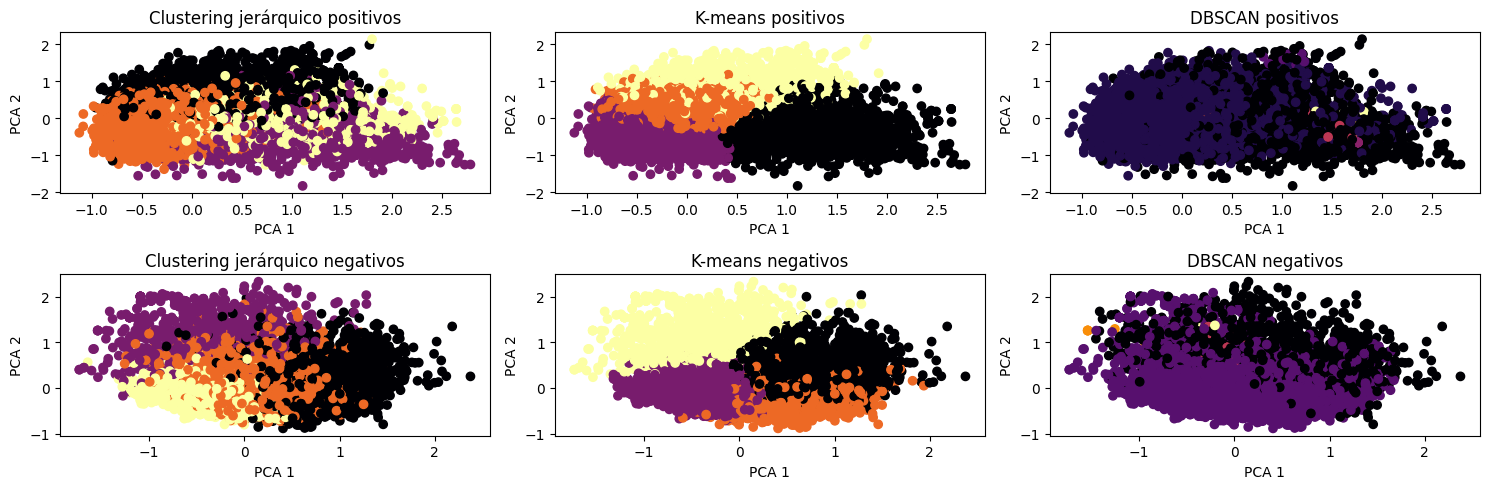

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(15, 5))

# Aglomerativo
axs[0, 0].scatter(positivos_pca[:,0], positivos_pca[:,1], c=Agglomerativo_p.labels_, cmap='inferno')
axs[0, 0].set_title('Clustering jerárquico positivos')
axs[0, 0].set_xlabel('PCA 1')
axs[0, 0].set_ylabel('PCA 2')

axs[1, 0].scatter(negativos_pca[:,0], negativos_pca[:,1], c=Agglomerativo_n.labels_, cmap='inferno')
axs[1, 0].set_title('Clustering jerárquico negativos')
axs[1, 0].set_xlabel('PCA 1')
axs[1, 0].set_ylabel('PCA 2')

# K-means

axs[0, 1].scatter(positivos_pca[:,0], positivos_pca[:,1], c=kmeans_p.labels_, cmap='inferno')
axs[0, 1].set_title('K-means positivos')
axs[0, 1].set_xlabel('PCA 1')
axs[0, 1].set_ylabel('PCA 2')

axs[1, 1].scatter(negativos_pca[:,0], negativos_pca[:,1], c=kmeans_n.labels_, cmap='inferno')
axs[1, 1].set_title('K-means negativos')
axs[1, 1].set_xlabel('PCA 1')
axs[1, 1].set_ylabel('PCA 2')

# DBSCAN

axs[0, 2].scatter(positivos_pca[:,0], positivos_pca[:,1], c=dbscan_p.labels_, cmap='inferno')
axs[0, 2].set_title('DBSCAN positivos')
axs[0, 2].set_xlabel('PCA 1')
axs[0, 2].set_ylabel('PCA 2')

axs[1, 2].scatter(negativos_pca[:,0], negativos_pca[:,1], c=dbscan_n.labels_, cmap='inferno')
axs[1, 2].set_title('DBSCAN negativos')
axs[1, 2].set_xlabel('PCA 1')
axs[1, 2].set_ylabel('PCA 2')

plt.subplots_adjust(wspace=0.1, hspace=0)
plt.tight_layout()

plt.savefig('Figuras/flair/clustering_pos_neg.png')
plt.show()